# Traffic Sign Recognition

The Dataset: 

# Initialization

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pathlib
import os
import timeit
import itertools

# Keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax

# sklearn
from sklearn.metrics import confusion_matrix

# MLOps
import wandb
from wandb.keras import WandbCallback

# General Parameters

In [31]:
# get num of classes
def get_num_classes(path):
    num_cats = 0
    for fname in os.listdir(path):
        try:
            bool = type(int(fname)) is int
            num_cats +=1
        except:
            pass
    return num_cats

In [32]:
# location of the data
base_dir = './dataset/GTSRB'
train_dir = './dataset/GTSRB/Train'
test_dir = './dataset/GTSRB/Test'

# dataset metadata
train_meta = './dataset/GTSRB/Train.csv'
test_meta = './dataset/GTSRB/Test.csv'

## Helper Functions

In [33]:
def plot_results(history, simple_style=False):
    # Results analysis:
    if simple_style:
        losses = pd.DataFrame(history.history, columns=['loss', 'val_loss'])
        accuracies = pd.DataFrame(history.history, columns=['acc', 'val_acc'])
        losses.plot()
        accuracies.plot()
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
        plt.plot(epochs, val_acc, 'b', color='gray', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()

        plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
        plt.plot(epochs, val_loss, 'b', color='gray', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# plot Confusion Matrix
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## MLOps

Weights an Biases init

In [34]:
!wandb login

wandb: Currently logged in as: gaspia (use `wandb login --relogin` to force relogin)


In [35]:
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

# Dataset exploration and preprocessing

In [36]:
# training dataset

def get_train_val_data(train_dir, img_width, img_height, batch_size, seed):
    #training dataset
    train_datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        shuffle=True,
        seed=seed,
        class_mode='categorical')

    # validation dataset
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',    
        seed=seed,
        class_mode='categorical'
        )

    return train_generator, val_generator

def get_test_data(test_dir, labels_path, img_width, img_height, batch_size):
    #test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(labels_path, dtype=str),
        directory = test_dir,
        x_col = 'Path',
        y_col = 'ClassId',
        target_size=(img_width,img_height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical'
        )
    
    return test_generator

In [37]:
train_generator, val_generator = get_train_val_data(train_dir, img_width, img_height, batch_size, seed=1)

Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [38]:
test_generator = get_test_data(base_dir, test_meta, img_width, img_height, batch_size)

Found 12630 validated image filenames belonging to 43 classes.


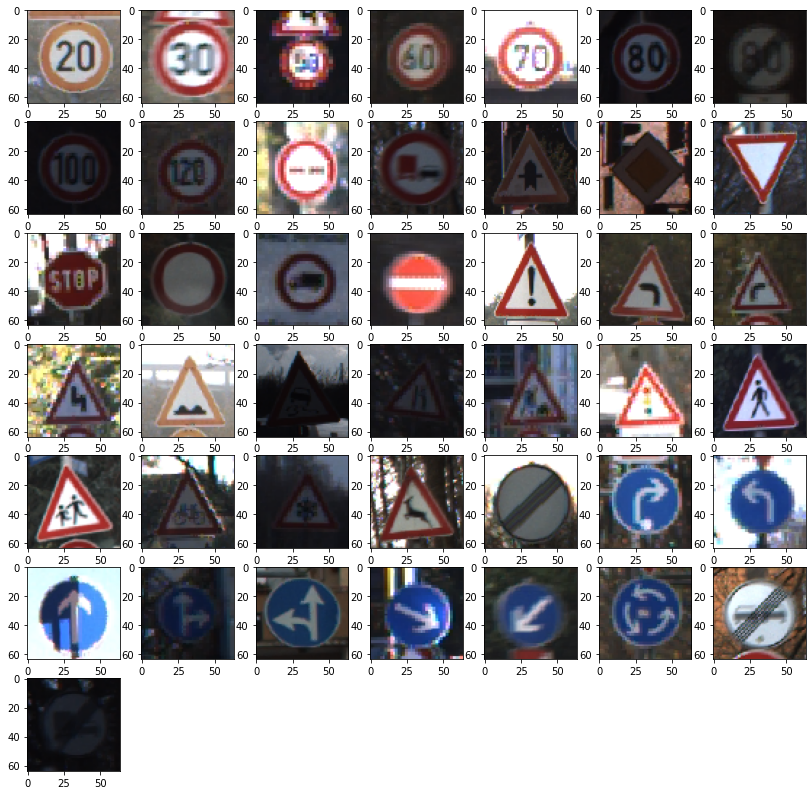

In [39]:
# Visualizing all the different Signs
img_dir = pathlib.Path(train_dir)
plt.figure(figsize=(14,14))
index = 0
for i in range(cat_num):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(img_width, img_height))
    plt.imshow(img)
plt.show()

## Class Distribution

In [40]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

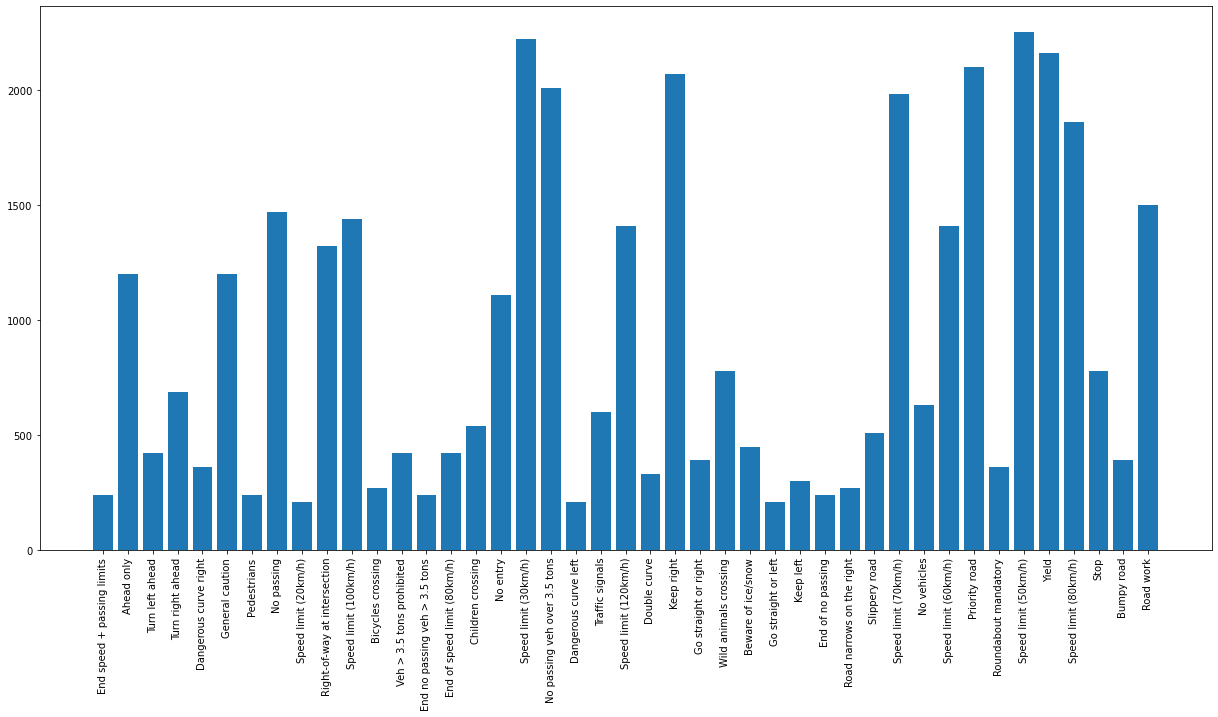

In [41]:
# determining the training data distribution per category
folders = next(os.walk(train_dir))[1]

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Analysis of the dataset

1. We can tell the image size is 
2. Some of the images have issues with low lighting / contrast / saturation which may become a problem for the model
3. The data is highly unbalanced

# Model Architectures

## Generic Paramters

In [63]:
#Generic parameters
img_width, img_height = 64, 64
batch_size = 100
cat_num = get_num_classes(train_dir)

# mlops
mlops_config = {
    "batch_size": batch_size,
    "img_width": img_width,
    "img_height": img_height,
    "cat_num": cat_num
}

## Baseline

The first CNN we are going to build consists on the following: 
1. A Convolutional layer followed by a MaxPooling layer; 
2. A second Convolutional layer followed by another MaxPooling layer; 
3. A Flatten layer (this is the input layer for the fully connected part of the CNN); 
4. A Dense Layer (this is the first hidden layer for the fully connected part of the CNN)
5. A second Dense layer (this is the output layer for the fully connected part of the CNN).
<br>

Please be mindful regarding the details below:
- The first and second Convolutional layers should contain 32 neurons (filters), with a filter of size 3x3 and an input shape of 64x64x3;
- The first and second MaxPooling layer should have a size of 2x2;
- The first Dense layer should have 128 neurons and the activation function should be the relu, while the second Dense layer should contain 1 neuron and the softmax as the activation function.

In [42]:
baseline_model = Sequential()
# Refference: DLNN lecture week 6
# Add the requested layers here (don't forget to import them first):
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid', input_shape=(64, 64, 3)))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
baseline_model.add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))
# MLP - input layer
baseline_model.add(Flatten())
# MLP - hidden layer
baseline_model.add(Dense(units=128, activation=relu))
# MLP - output layer
baseline_model.add(Dense(units=43, activation=softmax))

# Check built model:
baseline_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_10 (Dense)            (None, 128)              

### Training And Evaluating The Model

In [43]:
from tensorflow.keras import optimizers 

baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [64]:
# Common attributes:
mlops_config['steps_per_epoch'] = 5
mlops_config['epochs'] = 40
mlops_config['validation_steps'] = 20
mlops_config['loss'] = 'binary_crossentropy'
mlops_config['optimizer'] = 'adam'
mlops_config['metrics'] = ['acc']

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

mlops_config['patience'] = 5
early_stopping = EarlyStopping (patience=mlops_config['patience'], monitor='val_loss', mode='min', restore_best_weights=True)

In [48]:
# MLOps init and callback
wandb.init(name='CNN_TS_baseline' , project='CNN_TS', config=mlops_config)

start = timeit.default_timer()

history_baseline = baseline_model.fit(
    train_generator,
    steps_per_epoch=mlops_config['steps_per_epoch'],
    validation_data=val_generator,
    validation_steps=mlops_config['validation_steps'],
    epochs=mlops_config['epochs'],
    callbacks=[WandbCallback(),early_stopping])

stop = timeit.default_timer()
print('Time Elapsed: ', stop - start)
wandb.log({'time-elapsed': stop - start})

wandb.finish()

Epoch 1/40
5/5 [==============================] - 11s 3s/step - loss: 0.0645 - acc: 0.4420 - val_loss: 0.0713 - val_acc: 0.3725
Epoch 2/40
5/5 [==============================] - 9s 2s/step - loss: 0.0612 - acc: 0.4560 - val_loss: 0.0675 - val_acc: 0.4355
Epoch 3/40
5/5 [==============================] - 9s 2s/step - loss: 0.0601 - acc: 0.5000 - val_loss: 0.0680 - val_acc: 0.4245
Epoch 4/40
5/5 [==============================] - 8s 2s/step - loss: 0.0569 - acc: 0.5360 - val_loss: 0.0690 - val_acc: 0.4040
Epoch 5/40
5/5 [==============================] - 7s 2s/step - loss: 0.0578 - acc: 0.5340 - val_loss: 0.0667 - val_acc: 0.4385
Epoch 6/40
5/5 [==============================] - 7s 2s/step - loss: 0.0531 - acc: 0.5840 - val_loss: 0.0668 - val_acc: 0.4435
Epoch 7/40
5/5 [==============================] - 7s 2s/step - loss: 0.0587 - acc: 0.4940 - val_loss: 0.0661 - val_acc: 0.4515
Epoch 8/40
5/5 [==============================] - 6s 1s/step - loss: 0.0548 - acc: 0.5620 - val_loss: 0.0657 -

acc,▁▁▂▃▃▄▂▄▃▄▃▅▅▅▅▃▄▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇██▇█▇█▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▇▆▆▅▇▆▇▅▆▅▅▅▄▆▅▅▄▄▃▄▃▃▃▄▃▂▃▂▂▂▃▂▂▂▁▂▁▂
time-elapsed,▁
val_acc,▁▃▂▂▃▃▃▃▃▄▃▄▃▄▄▅▃▄▅▅▅▅▅▅▆▅▇▆▇▆█▇▇█▇█████
val_loss,█▇▇▇▆▇▆▆▆▆▆▆▇▅▅▅▅▅▄▄▄▄▃▄▃▄▂▃▃▃▂▁▁▁▂▁▁▁▁▁
acc,0.73
best_epoch,39
best_val_loss,0.04977
epoch,39
loss,0.03947


In [49]:
baseline_model.save('TS_CNN_baseline.h5')

/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_4497/3596228741.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_4497/3596228741.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='gray', label='Validation acc')
/var/folders/6k/dg5hh42s51s9mngqnvp9kqlw0000gp/T/ipykernel_4497/3596228741.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
/var/folders/6k/dg5hh42s51s9mngqnvp9kq

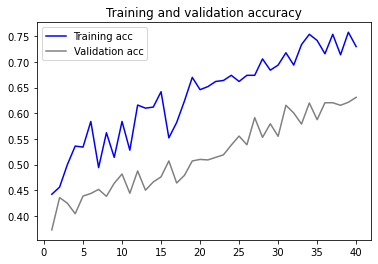

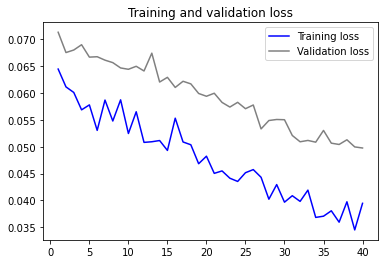

In [50]:
plot_results(history_baseline)

Confusion matrix, without normalization
[[ 0  4  6 ...  2  5  1]
 [ 0 36 53 ... 20 44 28]
 [ 1 19 36 ... 15 54 20]
 ...
 [ 1 18 28 ... 14 30 16]
 [ 0 19 26 ... 17 27 13]
 [ 1 27 33 ...  5 33 15]]


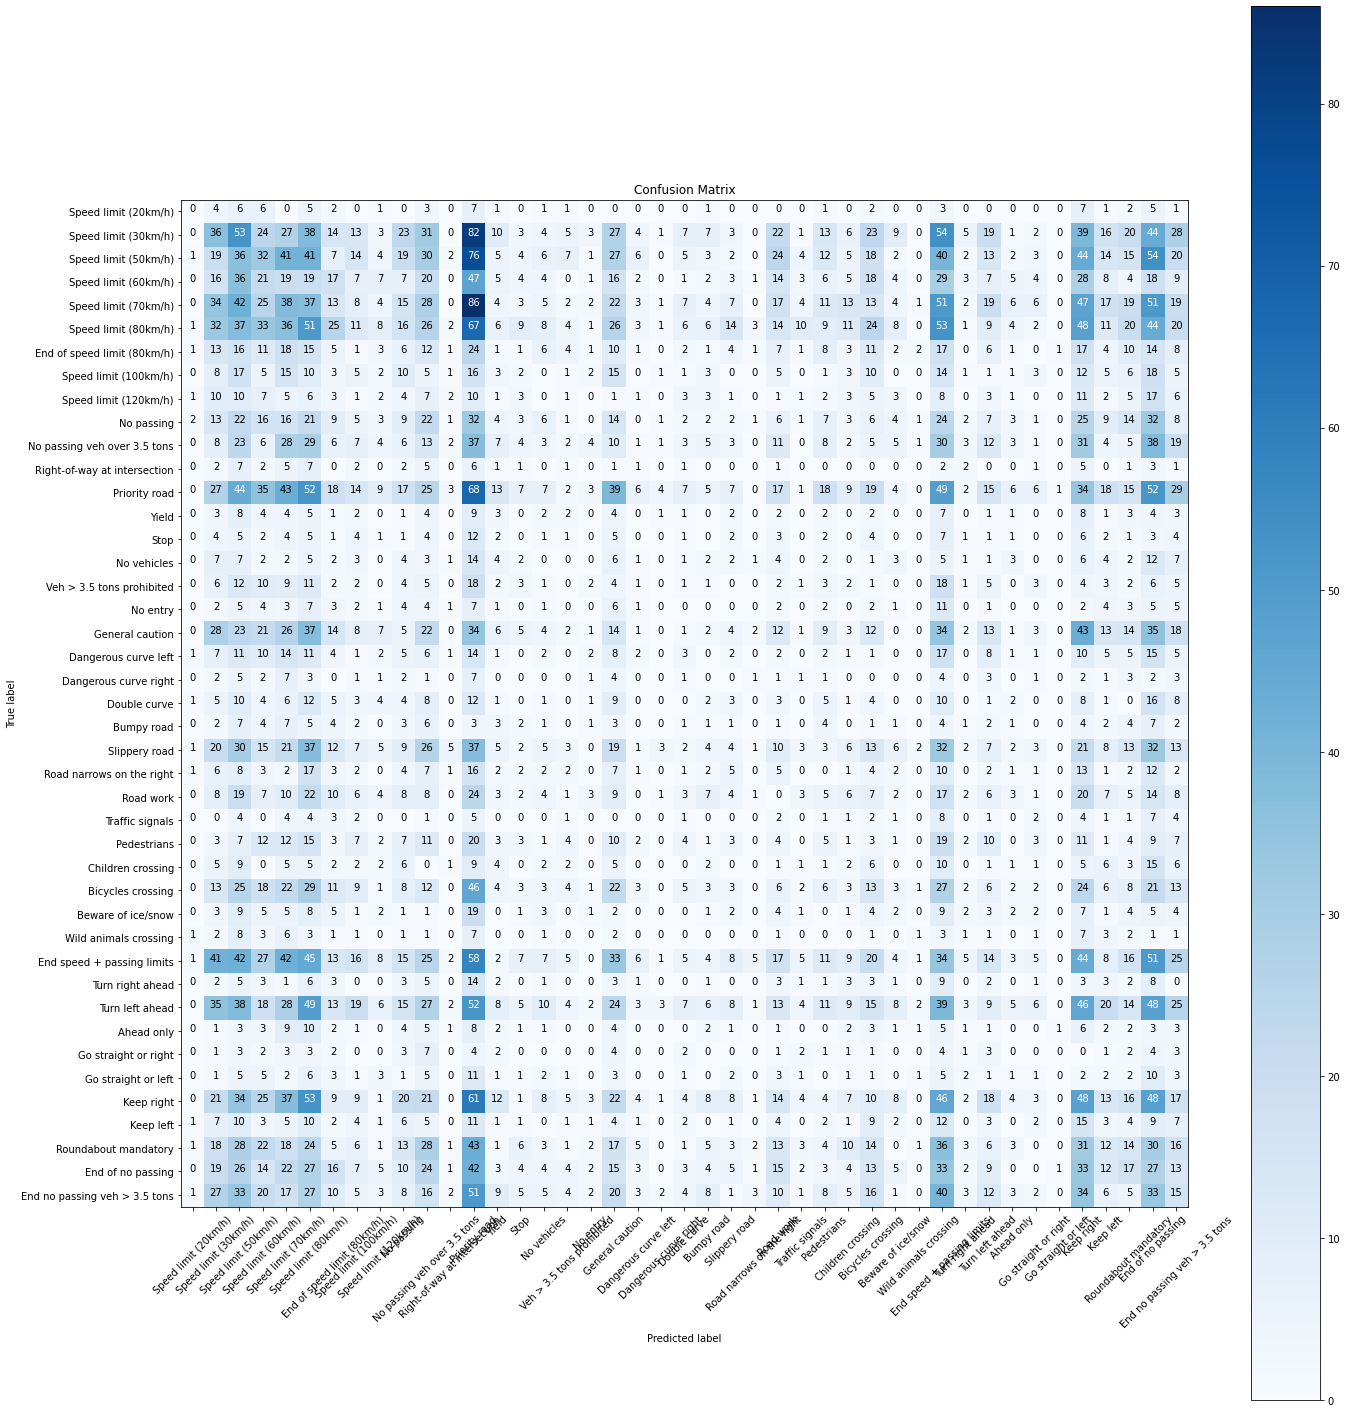

In [51]:
# predictions on Test data

Y_pred = baseline_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=list(classes.values()), title='Confusion Matrix')

## Baseline - Kernel Size variations

In [86]:
# trying different kernel sizes
kernels = [5, 9, 13, 25]
models = [0] * (len(kernels))
mlops_config_kernels = models.copy()

In [87]:
# Generic parameters and call backs
from tensorflow.keras.callbacks import EarlyStopping

patience = 5

early_stopping = EarlyStopping (patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)

In [88]:
for i in range(len(models)):
    models[i] = Sequential()
    models[i].add(Conv2D(filters=32, kernel_size = kernels[i], strides = (1,1), activation = relu, padding = 'valid', input_shape=(64, 64, 3)))
    models[i].add(MaxPooling2D(pool_size=2))
    models[i].add(Conv2D(filters=32, kernel_size = (3, 3), strides = (1,1), activation = relu, padding = 'valid'))
    models[i].add(MaxPooling2D(pool_size=2))
    models[i].add(Flatten())
    models[i].add(Dense(500, activation='relu'))
    models[i].add(Dense(43, activation='softmax'))
    models[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # Common mlops attributes:
    mlops_config_kernels[i]= mlops_config.copy()
    mlops_config_kernels[i]['steps_per_epoch'] = 5
    mlops_config_kernels[i]['epochs'] = 40
    mlops_config_kernels[i]['validation_steps'] = 20
    mlops_config_kernels[i]['loss'] = 'binary_crossentropy'
    mlops_config_kernels[i]['optimizer'] = 'adam'
    mlops_config_kernels[i]['metrics'] = ['acc']
    mlops_config_kernels[i]['patience'] = 5
    mlops_config_kernels[i]['callbacks'] = ['EarlyStopping']
    mlops_config_kernels[i]['kernel_size'] = kernels[i]

In [79]:
mlops_config_kernels[0]['steps_per_epoch']

5

In [94]:
history_kernels_kernels = [0] * (len(kernels))

for i in range(len(history_kernels_kernels)):
  # mlops
  start = timeit.default_timer()
  wandb.init(name='CNN_TS_baseline_kernels_' + str(i) , project='CNN_TS', config=mlops_config_kernels[i])
  # model fit
  history_kernels_kernels[i] = models[i].fit(
      train_generator,
      steps_per_epoch=mlops_config_kernels[i]['steps_per_epoch'],
      validation_data=val_generator,
      validation_steps=mlops_config_kernels[i]['validation_steps'],
      epochs=mlops_config_kernels[i]['epochs'],
      callbacks=[WandbCallback(),early_stopping],
      verbose=0)

  print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation loss={3:.5f}'.\
    format(mlops_config_kernels[i]['kernel_size'], mlops_config_kernels[i]['epochs'], max(history_kernels_kernels[i].history['acc']), max(history_kernels_kernels[i].history['val_loss'])))
  
  # mlops
  stop = timeit.default_timer()
  print('Time Elapsed: ', stop - start)
  wandb.log({'time-elapsed': stop - start})
  wandb.log({'training-accuracy': max(history_kernels_kernels[i].history['acc'])})
  wandb.log({'validation-loss': max(history_kernels_kernels[i].history['val_loss'])})

  wandb.finish()


Model with filters 5x5, epochs=40, training accuracy=0.95800, validation accuracy=0.02965
Time Elapsed:  76.59401034199982


acc,▁▇█▅▇▃▆▄
epoch,▁▂▃▄▅▆▇█
loss,█▂▁▃▃▃▁▂
time-elapsed,▁
training-accuracy,▁
val_acc,▆█▇▅▁▄▃▄
val_loss,▃▂▁█▇▃█▄
validation-accuracy,▁
acc,0.944
best_epoch,2
best_val_loss,0.02635


Model with filters 9x9, epochs=40, training accuracy=0.79200, validation accuracy=0.26226
Time Elapsed:  298.9299590890005


acc,▁▂▂▂▂▂▂▂▂▂▃▂▃▃▃▄▄▄▄▅▄▅▅▆▆▆▆▆▆▇▇▇▇██▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time-elapsed,▁
training-accuracy,▁
val_acc,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇███
val_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
validation-accuracy,▁
acc,0.792
best_epoch,37
best_val_loss,0.04267


In [93]:
 wandb.finish()

acc,▁▃▃▂▂▄▃▂▄▄▆▆▇▆▆▇▆▇▆▆▆▅▇▆▇█▇▇█▇▇
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▇▆▇▅▆▆▅▅▃▅▃▃▃▁▃▂▃▃▂▃▂▃▂▂▂▂▁▁▁
val_acc,▁▃▃▂▃▃▂▃▅▅▅▄▄▅▅▅▆▄▅▇▅▇▆█▆█▇▆▇▇▇
val_loss,█▆▆▇▅▅▇▆▅▅▄▄▆▄▅▅▃▅▃▃▄▂▅▂▄▁▁▂▂▂▁
acc,0.946
best_epoch,25
best_val_loss,0.02571
epoch,30
loss,0.01214
val_acc,0.847
